In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [6]:
# Learn A from Austin
H_au, A_au, T_au = learn_HAT(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost)

In [20]:
pd.DataFrame(A_au[6, :, :])

,0,1
0,0.503826,0.110311
1,0.302086,0.023089


In [21]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)

In [22]:
from sklearn.model_selection import train_test_split, KFold

In [23]:
n_splits = 10


In [24]:
from common import compute_rmse

In [25]:
np.arange(0.1, 1.0, 0.1)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [27]:
pred = {}
sd = {}
out = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'
for random_seed in range(10):
    pred[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print(random_seed,"\n")
    for train_percentage in range(10, 110, 10):
        print train_percentage
        for train_max, test in kf.split(df):

            num_train = int((train_percentage*len(train_max)/100)+0.5)
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            train_ix = df.index[train]
            test_ix = df.index[test]
           
            num_test = len(test_ix)
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            tensor_copy = tensor.copy()
            # First n
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_au)
            assert(np.allclose(A, A_au))
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


(0, '\n')
10
20
30
40
50
60
70
80
90
100
(1, '\n')
10
20
30
40
50
60
70
80
90
100
(2, '\n')
10
20
30
40
50
60
70
80
90
100
(3, '\n')
10
20
30
40
50
60
70
80
90
100
(4, '\n')
10
20
30
40
50
60
70
80
90
100
(5, '\n')
10
20
30
40
50
60
70
80
90
100
(6, '\n')
10
20
30
40
50
60
70
80
90
100
(7, '\n')
10
20
30
40
50
60
70
80
90
100
(8, '\n')
10
20
30
40
50
60
70
80
90
100
(9, '\n')
10
20
30
40
50
60
70
80
90
100


In [28]:
from common import compute_rmse_fraction

In [30]:
out = {}
for random_seed in range(10):
    out[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out[random_seed][appliance] = {}
        for f in range(10, 110, 10):
            s = pd.concat(pred[random_seed][appliance][f]).ix[df.index]
            if appliance=="hvac":
                    out[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

In [31]:
means_df = pd.Panel(out).mean(axis=0)
means_df

,dw,fridge,hvac,mw,oven,wm
10,1.957949,11.675579,20.032584,2.372723,2.446823,0.997089
20,1.900259,11.293426,17.674085,2.327941,2.329474,0.959304
30,1.880416,11.083748,17.711442,2.301545,2.270807,0.939887
40,1.853396,10.723234,17.822501,2.285436,2.157948,0.926237
50,1.845346,10.482095,17.406797,2.279233,2.102834,0.915706
60,1.837418,10.290232,16.898504,2.270316,2.064302,0.908209
70,1.833359,10.217696,16.898869,2.268465,2.052633,0.904615
80,1.829885,10.232384,16.851187,2.266425,2.052458,0.903039
90,1.829449,10.206405,16.640315,2.265416,2.052341,0.901883
100,1.828544,10.264974,16.469496,2.266615,2.056533,0.904428


In [32]:
std_df = pd.Panel(out).std(axis=0)
std_df

,dw,fridge,hvac,mw,oven,wm
10,0.043624,6.314656e-01,1.940169,5.736740e-02,1.044141e-01,3.174685e-02
20,0.031739,5.218951e-01,0.993728,2.965193e-02,1.202501e-01,2.256467e-02
30,0.024790,4.248436e-01,1.133412,2.432408e-02,8.798880e-02,2.053761e-02
40,0.009054,4.274628e-01,1.652766,1.177746e-02,7.030122e-02,1.298954e-02
50,0.010197,3.890715e-01,1.612082,9.319932e-03,4.777442e-02,1.516008e-02
60,0.005227,3.098195e-01,1.159084,6.661593e-03,2.988887e-02,1.065689e-02
70,0.005835,3.093508e-01,0.798764,5.144554e-03,2.943298e-02,1.184936e-02
80,0.005040,2.440449e-01,0.514539,4.583825e-03,1.984908e-02,8.723644e-03
90,0.003044,2.059085e-01,0.198715,4.253313e-03,1.520586e-02,7.436784e-03
100,0.000000,1.872445e-15,0.000000,4.681111e-16,4.681111e-16,1.170278e-16


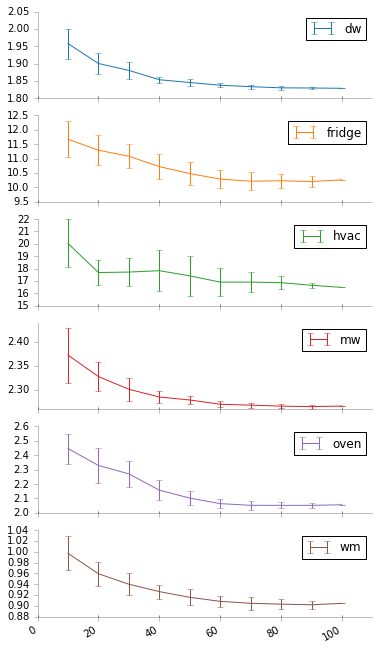

In [35]:
ax = means_df.plot(subplots=True, yerr=std_df, figsize=(6, 12), xlim=(0, 110), colors=tableau20blind[::2])
for a in ax:
    format_axes(a)

In [37]:
st = pd.HDFStore('transfer.h5', mode='a')
st['/transfer_mean'] = means_df
st['/transfer_sd'] = std_df
print st.keys()
st.close()

['/normal_mean', '/normal_sd', '/transfer_mean', '/transfer_sd']


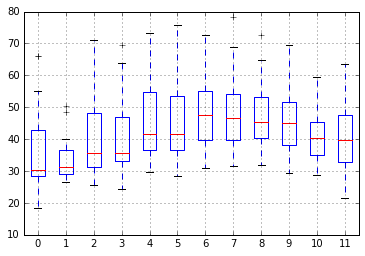

In [85]:
#prediction_appliance.boxplot()
gt_appliance = df[['%s_%d' %(appliance, month) for month in range(1, 13)]]
gt_appliance.columns = prediction_appliance.columns
gt_appliance.boxplot()

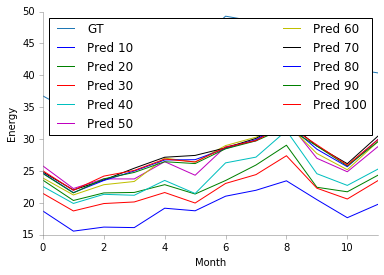

In [113]:
gt_appliance.mean().plot(label='GT', color=tableau20blind[::2][0])
for f in range(10, 110, 10):
  
    random_seed=2
    appliance='fridge'
    prediction_appliance = pd.concat(pred[random_seed][appliance][f]).ix[df.index]
    prediction_appliance.mean().plot(label='Pred '+str(f))
plt.legend(loc=0, mode="expand", ncol=2)
format_axes(plt.gca())
plt.xlabel("Month")
plt.ylabel("Energy")

In [114]:
import pickle
pickle.dump(pred, open("predictions/transfer_pred.pkl", 'w'))

In [117]:
!ls -lah predictions/transfer_pred.pkl

-rw-r--r--  1 nipunbatra  staff    10M Jun 26 16:59 predictions/transfer_pred.pkl
